In [86]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)

In [6]:
file1 = "/Users/szeng/Desktop/Projects/WebScraping/scrapy_instagram/scraped/hashtag/grapes/09-07-2019_20"
file2 = "/Users/szeng/Desktop/Projects/WebScraping/scrapy_instagram/scraped/hashtag/love/17-07-2019_04"
file3 = "/Users/szeng/Desktop/Projects/WebScraping/scrapy_instagram/scraped/hashtag/dog/09-07-2019_20"
df1 = pd.read_json(file1, lines=True)
df2 = pd.read_json(file2, lines=True)  
df3 = pd.read_json(file3, lines=True)  

In [87]:
df = pd.concat([df1, df3])

In [88]:
df

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp
0,🍇🍇 @glamandglitsnails @nailsupplyglamour #grapes #NikkiNails #nailsofinstagram #nailsonfleek #nailfashion #nailsaddict,0,https://scontent-mia3-1.cdninstagram.com/vp/502abe0a1cfd3fed9a227be5d85ef38b/5DB8E423/t51.2885-15/e35/s1080x1080/66152509_207013253548693_2682470079744198730_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084520251730945280,13,_nikki_nails,BzttB_rh-Uz,1562714199
1,"100 calories snacks. Frozen red grapes \nWhy snack on rubbish when these frozen sweet treats can be obtained right from nature? About 30 red grapes are 100 calories. Freeze before hand and enjoy these anytime you get the munchies. Disclaimer: they are high in vitamin C and antioxidants, and help lower blood sugar and boost immunity. Go on then, choose better feel better. \n#100caloriesnacks #footphotography #noirphotography #grapes #fruit #vegan #healthy #snacktime #frozentreats #hunger #delicious #summer",0,https://scontent-mia3-1.cdninstagram.com/vp/2e38c2ec297310f5d80914bf97df151f/5DADB11C/t51.2885-15/e35/p1080x1080/65495587_472209090273382_7849298862514672016_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084523617516829952,4,mealpreppedmom,Bztty-UALyO,1562714601
2,🍇🍇 Snack de hoy: uvas congeladas 🌟🌟\n.\n.\n.\n.\n.\n.\n.\n#healthylifestyle #healthy #healthyhabits #healthyfood #healthyrecipes #healthy #healthybreakfast #healthyfoodidea #nutritiontips #nutrideas #nutricioninteligente #nutritips #nutritip #healthylifestyles #nutritiontip #nutrionist #nutritional #nutriologa #nutricionista #nutricion #nutricao #nutrideas #nutritious #grapes #grape,2,https://scontent-mia3-1.cdninstagram.com/vp/097688cbfb69b1caa75e849f992c90b5/5DA7E425/t51.2885-15/e35/65535963_2290813217903291_8922548229905795729_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084523564695120128,26,eatnutricion,BzttyNHlWlr,1562714594
3,"My #smoothie for tomorrow bc my hand FINALLY healed enough to open the bullet :) (it's been weeks)\n.\n.\nMy estrogen has been pretty high.... and I have an extensive family history of #female #cancers (legitimately extensive history) ..\n..\nso this smoothie has #broccoli #DIM and #resveratrol bc they are fantastic at binding/lowering estrogens 🥦🥦.... ..\n..\nAnd also #berries (use berries if you have #GERD or #reflux ) 🍓 #spinach #turmeric ( 💢 #anticancer 💢 ) 👈🚫❌ .\n.\n#cinnamon (lowers blood pressure) #grapes (additional resveratrol) #groundflax #tomatoes (which I hate) #bcomplex #vitaminD #omegas and VERY importantly, 10O bill CFUs of #probiotics .\n.\n#chapteronewellness #createhealth #preventingdisease #feelinggood #optimalwellness #healthcarenotsickcare #docere #micronutrients #nutrients",0,https://scontent-mia3-1.cdninstagram.com/vp/f1ebbefec138232207a5a393ac1c50dc/5DB8CD19/t51.2885-15/e35/64860094_954232424914641_837046393154486726_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084522696927726080,6,drmpettitt,Bzttlk8ncnJ,1562714491
4,"Charcuterie boards have won me over. (Love this picture? @lebadphotography took it). We use them as the main coarse and everyone can mix and match all of the amazing deliciousness. I am so in love, this week we're going to make a dessert grazing board... Marshmallows, chocolate dip, caramel dip, strawberries and more... To order dm. #momboss #kidsEating #kosher #KosherCaterer #kosherbaltimore #sweetandgoodcatering #sweetandgood #charcuterieboard #feedingpikesville #foodie #beeffry #pancetta #beefjerky #salami #pepperoni #freezedriedmango #grapes #proudtobeanamerican #cuttingboard #usa #simchas #events #barmitzvah #batmitzvah #weddings",1,https://scontent-mia3-1.cdninstagram.com/vp/f4d42e51015d0d1f52762f722f2d6dd2/5DC6856D/t51.2885-15/e35/64221462_161582874888430_6188362951921754408_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084520552857773056,12,sweetandgoodcatering,BzttGYIFqQQ,1562714235
5,"Instead of popping bottles 🍾, we’re picking grapes 🍇 Our Champagne Grapes are almost ready for harvest 🚜 Keep on the lookout for our Sark’s

Some quick stats to look at the distribution of likes and comments (especially since these will be used as a training measure/a measure of how "good" a caption is)

In [89]:
print(f"Likes: \n\n{df['likes'].describe()}\n\n")
print(f"Comments: \n\n{df['comments'].describe()}\n\n")

Likes: 

count    1834.000000
mean     46.720829  
std      219.234709 
min      0.000000   
25%      7.000000   
50%      15.000000  
75%      31.000000  
max      6151.000000
Name: likes, dtype: float64


Comments: 

count    1834.000000
mean     1.648855   
std      5.081865   
min      0.000000   
25%      0.000000   
50%      0.000000   
75%      1.000000   
max      96.000000  
Name: comments, dtype: float64




We'll sort by likes and then sort by comments and take a look at the captions to see how they are. 

In [106]:
df.sort_values(by=['likes'], ascending=False)

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp,average_comments_and_likes
1201,Red wine stored in Bamboo🍷\nFollow me @theatreofartists 🔄\n.\nFollow 👇\n@theatreofartists\n@theatreofartists\n@theatreofartists .\n.\n#wine #redredwine #grapes #bamboo #bamboosticks #winetasting #winery,81,https://scontent-mia3-1.cdninstagram.com/vp/169eda5f3289178931a4c70599073f6a/5D272E5F/t51.2885-15/e35/65387349_156685885463854_426436406798604136_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2082833043906910208,6151,theatreofartists,BzntZ48hFgY,1562513137,3116.0
628,Prosecco grapes!😍😋⠀\nFollow me (@empty.fridge) for more! \nCredit:@newparadise30\nAll rights and credits reserved to the respective owners. #emptyfridgeblog\n.\n.\n. \n#mygarden #gardencentre #kitchengarden #gardenlife #gardeners #gardeningisfun #gardeningaustralia #gardening_feature #gardeningmakesmehappy #gardeningtips #macrogardener #gardeners #grapes,63,https://scontent-mia3-1.cdninstagram.com/vp/7d5b4f63c22e91b7cf09a117c83525e7/5D27421E/t51.2885-15/e35/67086310_151322899354712_5187638423915290972_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083546212397768192,4452,empty.fridge,BzqPj23FF3B,1562598412,2257.5
568,#wikifarmer #viticulture #vines #vineyards #vineyard #vineyardview #vineyardviews #grape #grapes #viticultura #viticulturaheroica #vineturkiye #agriculture #farming,1,https://scontent-mia3-1.cdninstagram.com/vp/5216d29eb24ca7186f90b7927d13b6e9/5DB4D010/t51.2885-15/e35/65311225_103020510954234_1753299379078181211_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083664769568642304,3691,wikifarmer,BzqqhF1IpUl,1562612218,1846.0
670,Literally no one: \nMe: the world needs a wine and cheese embroidery hoop 🙌🏻🍇🍷🧀🤤,11,https://scontent-mia3-1.cdninstagram.com/vp/c7671a6e6c838079784066da456aed9a/5DACF31B/t51.2885-15/e35/s1080x1080/65393821_455309591958991_8351666294803569374_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083523452737582336,1221,a_stitch_up,BzqKYqRnnVy,1562595372,616.0
1437,"Great chicken salad starts with juicy, tender chicken. To achieve that, we turn to the oven for a no-fuss cooking method. Tap the link in our profile to get the recipe.⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n#cookscountry #chickensalad #grapes #walnuts #chicken #mayo #creamy #sandwich #salad #recipe⁠\n⁠\n⁠",4,https://scontent-mia3-1.cdninstagram.com/vp/6ff6b43ca8277d9ffef1079442d5a75a/5DADF4B0/t51.2885-15/fr/e15/s1080x1080/66154060_2282863895297701_3569346120736006682_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083606103469301248,1195,cookscountry,BzqdLYxH55e,1562605225,599.5
34,You can’t say the pain you’ve got inside. Nor I can not express the pain I feel inside\n.\n.\n.\n.\n.\n.\n.\n#dog #dogsofinstagram #dogstagram #home #pic #instapic #picoftheday #photography #forever #photooftheday #instagood #instamoment #instadaily #love #friends #girl #instagirl #woman #beauty #instabeauty #memories #human #soul #animal #blessed #pain #feelings,0,https://scontent-mia3-1.cdninstagram.com/vp/dd1057a37718ccbef36e638b21c04643/5DA75F96/t51.2885-15/e35/40378544_558212631279917_4470809211354017232_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,1863932683900246272,1181,carme_dm,BneBOaFHViv,1536418112,590.5
329,my kind of spread 🧀🧀🧀🧀🧀🧀\n•\n•\n•\n•\n#cheese #cheesey #cheeseboard #charcuterie #charcuterieboard #briecheese #crackers #grapes #raisins #sdeats #sd #sandiego #sdfood #sdfoodie #sdfoodblogger #newyork #nyc #nyceats #nycfood #nycfoodie #toronto #torontofood #torontofoodie #toreats #food #foodie #eatingfortheinsta #buzzfeast #buzzfeedfood #carbbaby,34,https://scontent-mia3-1.cdninstagram.com/vp/40cb9081112bcff94d8d8a2aab10e372/5DA221D9/t51.2885-15/e35/39946886_1322659364538163_5029469783800676352_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,1860417440326733056,1152,carbbaby,BnRh84Yncyj,1535999063,593.0
1510,Did I mention the grapes 🍇 #grapes they’re so fresh and sweet right off the vine. The second #California venture away from the sea for me this year. It really feels like another oas

In [107]:
df.sort_values(by=['comments'], ascending=False)

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp,average_comments_and_likes
1262,🥯🥯M U F F I N • A N I M A L S 🐷🐥🐑\n.\nCan you be in love with a muffin animal? We think so 😂\n.\nCheck out these fab ways of serving muffins by @tea_with_kaia_and_thea and be sure to check her other posts 👀\n.\nWhich is your fav? We can't choose 🤷🏽‍♀️\n.\n.\n#snackplate #kidssnacks #kidsfood #kidapproved #foodforkids #feedingkids #pickyeaters #blwtoddler #blw #fruit #grapes #veggies #babyledweaning #weaning #toddlermeals #funfood #toddlerfood #toddlersnacks #toddlerfoodideas #kidssnacks #babyledfeeding #muffintray #blwideas #blwmeals #blwinspiration #toddler #toddlermeals #pickyeater #weaningtoddler #funfoodforkids #newfoods,96,https://scontent-mia3-1.cdninstagram.com/vp/a92a03cdfadf4e6204c223b43fa8c637/5DB3FEC6/t51.2885-15/e35/65424261_2531430227084198_628819846923489631_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2082975147456035840,747,kid_dish,BzoNtxMFXwf,1562530009,421.5
1201,Red wine stored in Bamboo🍷\nFollow me @theatreofartists 🔄\n.\nFollow 👇\n@theatreofartists\n@theatreofartists\n@theatreofartists .\n.\n#wine #redredwine #grapes #bamboo #bamboosticks #winetasting #winery,81,https://scontent-mia3-1.cdninstagram.com/vp/169eda5f3289178931a4c70599073f6a/5D272E5F/t51.2885-15/e35/65387349_156685885463854_426436406798604136_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2082833043906910208,6151,theatreofartists,BzntZ48hFgY,1562513137,3116.0
628,Prosecco grapes!😍😋⠀\nFollow me (@empty.fridge) for more! \nCredit:@newparadise30\nAll rights and credits reserved to the respective owners. #emptyfridgeblog\n.\n.\n. \n#mygarden #gardencentre #kitchengarden #gardenlife #gardeners #gardeningisfun #gardeningaustralia #gardening_feature #gardeningmakesmehappy #gardeningtips #macrogardener #gardeners #grapes,63,https://scontent-mia3-1.cdninstagram.com/vp/7d5b4f63c22e91b7cf09a117c83525e7/5D27421E/t51.2885-15/e35/67086310_151322899354712_5187638423915290972_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083546212397768192,4452,empty.fridge,BzqPj23FF3B,1562598412,2257.5
950,"I am absolutely loving my @cambromfg pans! With this big boy, my family is set for the week as far as fruit goes! The seal cover on it works great too! Can’t wait to have all of my refrigerators and pantries organized with #cambro! #chicksthatsmoke #partnership #teamcambro #fruitsalad #organized #watermelon #canteloupe #grapes #cottoncandygrapes #blueberries #foodsafe #foodprep #mealprep #prep #yum #pottymouthbbq #checkitoutbbq #delicious #sofresh #fresh #fruit",41,https://scontent-mia3-1.cdninstagram.com/vp/7dfbee04e24e8f5ee3f142bf2047f710/5DB2D83C/t51.2885-15/e35/65576419_478705076212171_2935569181980706780_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2082988022416378880,470,chicksthatsmoke,BzoQpH7hYv9,1562531544,255.5
56,Cyber #nike #shoes #sneakers #art #flame #fashion #style #hypebeast #meme #fire #sole #adidas #streetstyle #ootd #shoes #memes #wow #drawing #sneakerholic #streetwear #igsneakercommunity #cyber #swoosh #retro #navy #yellow #teal #purple #grapes,40,https://scontent-mia3-1.cdninstagram.com/vp/781bc41c6cbeaa21af33d707492f43f1/5DC5D8E0/t51.2885-15/e35/58468864_352628992043497_8263310371870671634_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2037092281728901632,747,efzay_efem,BxFNKMjJCHp,1557060345,393.5
1386,"Jestem dla siebie dobra, jestem dla siebie dobra, jestem dla siebie dobra....Aaaaaaa! 🤣🤣\n.\nAle mialam poranek. Jasny gwint! 😂 #pullingmyhairout\n.\nWszystko NIEZGODNIE Z planem . A tu trzeba zachowac twarz i udawać ze wszystko jest w jak najlepszym porządku. 🥴🙈🙈. .\nWyrwałam kilka włosów i nie wytrzymałam..... poszłam do sklepu i kupiłam.... winogrona. \nOd razu lepiej 😉\n.\n\nOne of those days...\n.\n U mnie kiedyś była szklanka wina, dzisiaj to paczka winogron #niejestzle \nWieczorem zaatakuje MBB ze zdwojona siła. \nLatwiej jest być dla siebie dobrym w te spokojne dni, kiedy mało się dzieje. ..🤪\n.\nA wy co robicie w te dni kiedy wszy

Just from a cursory glance, we can see a lot of potential issues. 

The first is that there are emojis, which'll be problematic because of how this problem can be envisioned. At run time, we'll be turning an image -> descriptive features (image classification)/relevant objects -> sequence/caption. For this training data, we can simply just match the sequence up to the hashtags present in the caption as well as any image features that we find. The sequence we're going to try and convert into a sequence embedding (BERT?). This is going to be a problem with emojis because we'll have to either strip them (not ideal since I believe that they're a relevant part of captions in instagram) or find some other way of encoding them. 

The second is that this doesn't seem to be a really reliable measure. We can see that the top few results don't give the best captions. And that there's a lot of preprocessing that needs to be done (get rid of hashtags, get rid of the "credit" lines, etc). 

The third is that we have multiple languages.



In [105]:
cols = ['likes', 'comments']
df['average_comments_and_likes'] = df[cols].astype(float).mean(axis=1)
df.sort_values(by=['average_comments_and_likes'], ascending=False)

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp,average_comments_and_likes
1201,Red wine stored in Bamboo🍷\nFollow me @theatreofartists 🔄\n.\nFollow 👇\n@theatreofartists\n@theatreofartists\n@theatreofartists .\n.\n#wine #redredwine #grapes #bamboo #bamboosticks #winetasting #winery,81,https://scontent-mia3-1.cdninstagram.com/vp/169eda5f3289178931a4c70599073f6a/5D272E5F/t51.2885-15/e35/65387349_156685885463854_426436406798604136_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2082833043906910208,6151,theatreofartists,BzntZ48hFgY,1562513137,3116.0
628,Prosecco grapes!😍😋⠀\nFollow me (@empty.fridge) for more! \nCredit:@newparadise30\nAll rights and credits reserved to the respective owners. #emptyfridgeblog\n.\n.\n. \n#mygarden #gardencentre #kitchengarden #gardenlife #gardeners #gardeningisfun #gardeningaustralia #gardening_feature #gardeningmakesmehappy #gardeningtips #macrogardener #gardeners #grapes,63,https://scontent-mia3-1.cdninstagram.com/vp/7d5b4f63c22e91b7cf09a117c83525e7/5D27421E/t51.2885-15/e35/67086310_151322899354712_5187638423915290972_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083546212397768192,4452,empty.fridge,BzqPj23FF3B,1562598412,2257.5
568,#wikifarmer #viticulture #vines #vineyards #vineyard #vineyardview #vineyardviews #grape #grapes #viticultura #viticulturaheroica #vineturkiye #agriculture #farming,1,https://scontent-mia3-1.cdninstagram.com/vp/5216d29eb24ca7186f90b7927d13b6e9/5DB4D010/t51.2885-15/e35/65311225_103020510954234_1753299379078181211_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083664769568642304,3691,wikifarmer,BzqqhF1IpUl,1562612218,1846.0
670,Literally no one: \nMe: the world needs a wine and cheese embroidery hoop 🙌🏻🍇🍷🧀🤤,11,https://scontent-mia3-1.cdninstagram.com/vp/c7671a6e6c838079784066da456aed9a/5DACF31B/t51.2885-15/e35/s1080x1080/65393821_455309591958991_8351666294803569374_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083523452737582336,1221,a_stitch_up,BzqKYqRnnVy,1562595372,616.0
1437,"Great chicken salad starts with juicy, tender chicken. To achieve that, we turn to the oven for a no-fuss cooking method. Tap the link in our profile to get the recipe.⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n⁠\n#cookscountry #chickensalad #grapes #walnuts #chicken #mayo #creamy #sandwich #salad #recipe⁠\n⁠\n⁠",4,https://scontent-mia3-1.cdninstagram.com/vp/6ff6b43ca8277d9ffef1079442d5a75a/5DADF4B0/t51.2885-15/fr/e15/s1080x1080/66154060_2282863895297701_3569346120736006682_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2083606103469301248,1195,cookscountry,BzqdLYxH55e,1562605225,599.5
329,my kind of spread 🧀🧀🧀🧀🧀🧀\n•\n•\n•\n•\n#cheese #cheesey #cheeseboard #charcuterie #charcuterieboard #briecheese #crackers #grapes #raisins #sdeats #sd #sandiego #sdfood #sdfoodie #sdfoodblogger #newyork #nyc #nyceats #nycfood #nycfoodie #toronto #torontofood #torontofoodie #toreats #food #foodie #eatingfortheinsta #buzzfeast #buzzfeedfood #carbbaby,34,https://scontent-mia3-1.cdninstagram.com/vp/40cb9081112bcff94d8d8a2aab10e372/5DA221D9/t51.2885-15/e35/39946886_1322659364538163_5029469783800676352_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,1860417440326733056,1152,carbbaby,BnRh84Yncyj,1535999063,593.0
34,You can’t say the pain you’ve got inside. Nor I can not express the pain I feel inside\n.\n.\n.\n.\n.\n.\n.\n#dog #dogsofinstagram #dogstagram #home #pic #instapic #picoftheday #photography #forever #photooftheday #instagood #instamoment #instadaily #love #friends #girl #instagirl #woman #beauty #instabeauty #memories #human #soul #animal #blessed #pain #feelings,0,https://scontent-mia3-1.cdninstagram.com/vp/dd1057a37718ccbef36e638b21c04643/5DA75F96/t51.2885-15/e35/40378544_558212631279917_4470809211354017232_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,1863932683900246272,1181,carme_dm,BneBOaFHViv,1536418112,590.5
1510,Did I mention the grapes 🍇 #grapes they’re so fresh and sweet right off the vine. The second #California venture away from the sea for me this year. It really feels like another oas

In [124]:
df['hashtags'] = df['caption'].str.split("#")
df

,caption,comments,display_url,id,likes,owner_name,shortcode,taken_at_timestamp,average_comments_and_likes,hashtags
0,🍇🍇 @glamandglitsnails @nailsupplyglamour #grapes #NikkiNails #nailsofinstagram #nailsonfleek #nailfashion #nailsaddict,0,https://scontent-mia3-1.cdninstagram.com/vp/502abe0a1cfd3fed9a227be5d85ef38b/5DB8E423/t51.2885-15/e35/s1080x1080/66152509_207013253548693_2682470079744198730_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084520251730945280,13,_nikki_nails,BzttB_rh-Uz,1562714199,6.5,"[🍇🍇 @glamandglitsnails @nailsupplyglamour , grapes , NikkiNails , nailsofinstagram , nailsonfleek , nailfashion , nailsaddict]"
1,"100 calories snacks. Frozen red grapes \nWhy snack on rubbish when these frozen sweet treats can be obtained right from nature? About 30 red grapes are 100 calories. Freeze before hand and enjoy these anytime you get the munchies. Disclaimer: they are high in vitamin C and antioxidants, and help lower blood sugar and boost immunity. Go on then, choose better feel better. \n#100caloriesnacks #footphotography #noirphotography #grapes #fruit #vegan #healthy #snacktime #frozentreats #hunger #delicious #summer",0,https://scontent-mia3-1.cdninstagram.com/vp/2e38c2ec297310f5d80914bf97df151f/5DADB11C/t51.2885-15/e35/p1080x1080/65495587_472209090273382_7849298862514672016_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084523617516829952,4,mealpreppedmom,Bztty-UALyO,1562714601,2.0,"[100 calories snacks. Frozen red grapes \nWhy snack on rubbish when these frozen sweet treats can be obtained right from nature? About 30 red grapes are 100 calories. Freeze before hand and enjoy these anytime you get the munchies. Disclaimer: they are high in vitamin C and antioxidants, and help lower blood sugar and boost immunity. Go on then, choose better feel better. \n, 100caloriesnacks , footphotography , noirphotography , grapes , fruit , vegan , healthy , snacktime , frozentreats , hunger , delicious , summer]"
2,🍇🍇 Snack de hoy: uvas congeladas 🌟🌟\n.\n.\n.\n.\n.\n.\n.\n#healthylifestyle #healthy #healthyhabits #healthyfood #healthyrecipes #healthy #healthybreakfast #healthyfoodidea #nutritiontips #nutrideas #nutricioninteligente #nutritips #nutritip #healthylifestyles #nutritiontip #nutrionist #nutritional #nutriologa #nutricionista #nutricion #nutricao #nutrideas #nutritious #grapes #grape,2,https://scontent-mia3-1.cdninstagram.com/vp/097688cbfb69b1caa75e849f992c90b5/5DA7E425/t51.2885-15/e35/65535963_2290813217903291_8922548229905795729_n.jpg?_nc_ht=scontent-mia3-1.cdninstagram.com,2084523564695120128,26,eatnutricion,BzttyNHlWlr,1562714594,14.0,"[🍇🍇 Snack de hoy: uvas congeladas 🌟🌟\n.\n.\n.\n.\n.\n.\n.\n, healthylifestyle , healthy , healthyhabits , healthyfood , healthyrecipes , healthy , healthybreakfast , healthyfoodidea , nutritiontips , nutrideas , nutricioninteligente , nutritips , nutritip , healthylifestyles , nutritiontip , nutrionist , nutritional , nutriologa , nutricionista , nutricion , nutricao , nutrideas , nutritious , grapes , grape]"
3,"My #smoothie for tomorrow bc my hand FINALLY healed enough to open the bullet :) (it's been weeks)\n.\n.\nMy estrogen has been pretty high.... and I have an extensive family history of #female #cancers (legitimately extensive history) ..\n..\nso this smoothie has #broccoli #DIM and #resveratrol bc they are fantastic at binding/lowering estrogens 🥦🥦.... ..\n..\nAnd also #berries (use berries if you have #GERD or #reflux ) 🍓 #spinach #turmeric ( 💢 #anticancer 💢 ) 👈🚫❌ .\n.\n#cinnamon (lowers blood pressure) #grapes (additional resveratrol) #groundflax #tomatoes (which I hate) #bcomplex #vitaminD #omegas and VERY importantly, 10O bill CFUs of #probiotics .\n.\n#chapteronewellness #createhealth #preventingdisease #feelinggood #optimalwellness #healthcarenotsickcare #docere #micronutrients #nutrients",0,https://scontent-mia3-1.cdninstagram.com/vp/f1ebbefec138232207a5a393ac1c50dc/5DB8CD19/t51.2885-15/e35/64860094_954232424914641_837046393154486726_n.jpg?_nc_ht=scontent-mia3-1.cdni

(0, 250)

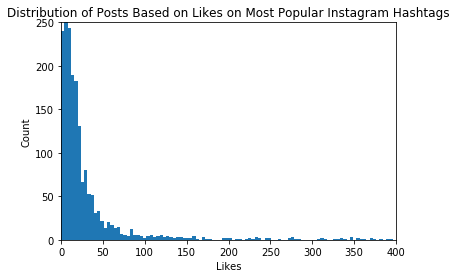

In [78]:
plt.hist(df["likes"], bins='auto')
plt.title("Distribution of Posts Based on Likes on Most Popular Instagram Hashtags")
plt.xlabel("Likes")
plt.ylabel("Count")
plt.xlim(xmin=0, xmax=400)
plt.ylim(ymin=0, ymax=250)

(0, 100)

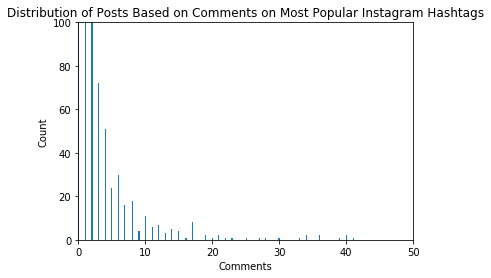

In [82]:
plt.hist(df["comments"], bins='auto')
plt.title("Distribution of Posts Based on Comments on Most Popular Instagram Hashtags")
plt.xlabel("Comments")
plt.ylabel("Count")
plt.xlim(xmin=0, xmax=50)
plt.ylim(ymin=0, ymax=100)